In [ ]:
!pip install -U transformers peft accelerate datasets trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 149.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 55.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.2
    Uninstalling transformers-4.57.2:
      Successfully uninstalled transformers-4.57.2
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0


In [ ]:
# import
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel, LoraConfig, get_peft_model
from trl import DPOTrainer, DPOConfig
from datasets import load_dataset
import pandas as pd
import json
import gc

print(f"PyTorch: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

PyTorch: 2.9.0+cu126
CUDA 사용 가능: True
GPU: NVIDIA A100-SXM4-80GB


In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

print("드라이브 마운트 완료!")

Mounted at /content/drive
드라이브 마운트 완료!


In [ ]:
# DPO 데이터 로드 (Train + Valid)

from datasets import load_dataset

# 분할된 데이터셋 경로
train_path = '/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo_dataset_from_pairwise_train.jsonl'
valid_path = '/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo_dataset_from_pairwise_valid.jsonl'

print("DPO 데이터셋 로드 중...")
train_dataset = load_dataset("json", data_files=train_path)['train']
valid_dataset = load_dataset("json", data_files=valid_path)['train']

print(f"Train 데이터셋: {len(train_dataset)}개")
print(f"Valid 데이터셋: {len(valid_dataset)}개\n")

# 데이터 구조 확인
print("=" * 80)
print("데이터셋 구조 확인")
print("=" * 80)
print(f"\nColumns: {train_dataset.column_names}\n")

# 첫 번째 샘플 출력
print("=" * 80)
print("[Train] 첫 번째 샘플")
print("=" * 80)
example = train_dataset[0]

print("\n Prompt:")
for msg in example['prompt']:
    print(f"  [{msg['role']}]: {msg['content'][:100]}{'...' if len(msg['content']) > 100 else ''}")

print("\n Chosen:")
for msg in example['chosen']:
    print(f"  [{msg['role']}]: {msg['content']}")

print("\n Rejected:")
for msg in example['rejected']:
    print(f"  [{msg['role']}]: {msg['content']}")

# Valid 샘플도 확인
print("\n" + "=" * 80)
print("[Valid] 첫 번째 샘플")
print("=" * 80)
example_valid = valid_dataset[0]
user_msg = [m for m in example_valid['prompt'] if m['role'] == 'user'][0]['content']
print(f"\n  User: {user_msg[:80]}{'...' if len(user_msg) > 80 else ''}")
print(f"  Chosen: {example_valid['chosen'][0]['content'][:80]}{'...' if len(example_valid['chosen'][0]['content']) > 80 else ''}")
print(f"  Rejected: {example_valid['rejected'][0]['content'][:80]}{'...' if len(example_valid['rejected'][0]['content']) > 80 else ''}")

print("\n" + "=" * 80)
print("데이터셋 로드 완료!")
print("=" * 80)
print(f"  Train: {len(train_dataset)}개")
print(f"  Valid: {len(valid_dataset)}개")

DPO 데이터셋 로드 중...


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Train 데이터셋: 1124개
Valid 데이터셋: 140개

데이터셋 구조 확인

Columns: ['prompt', 'chosen', 'rejected']

[Train] 첫 번째 샘플

 Prompt:
  [system]: You are an AI that generates a single, concise clarifying question when a user's query is ambiguous....
  [user]: [EM|UNF] Does Ocale v badia have direct developer developmental mode?

 Chosen:
  [assistant]: ["Who wrote it to?"

 Rejected:
  [assistant]: 

[Valid] 첫 번째 샘플

  User: [EM|UNF] Is Deschampsamps robusta's conservation status vulnerable?
  Chosen: Generate the output: Is the word 'vulnerable' referring to a threat category in ...
  Rejected: WHAT's conservation status vulnerable?

데이터셋 로드 완료!
  Train: 1124개
  Valid: 140개


In [ ]:
# 모델 로드

import gc
gc.collect()
torch.cuda.empty_cache()

sft_path = '/content/drive/MyDrive/Colab Notebooks/woke-odds/checkpoint-best'
base_model_name = "microsoft/Phi-4-mini-reasoning"

print("모델 로드 중...\n")

# Base 모델 로드
print("Base 모델 로드...")
model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)
print("Base 모델 로드 완료")

# SFT LoRA adapter를 두 번 로드 (같은 모델 인스턴스에!)
print("\n SFT LoRA adapter 로드...")
from peft import PeftModel

# 첫 번째: trainable adapter (학습할 것)
model = PeftModel.from_pretrained(
    model,
    sft_path,
    adapter_name="dpo_train",
    is_trainable=True
)
print("'dpo_train' adapter 로드 완료")

# 두 번째: reference adapter (frozen, 비교용)
model.load_adapter(sft_path, adapter_name="dpo_reference")
print("'dpo_reference' adapter 로드 완료")

# Tokenizer 로드
print("\n Tokenizer 로드...")
tokenizer = AutoTokenizer.from_pretrained(sft_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"  # DPO에서는 left padding 권장!
print("Tokenizer 로드 완료")

# 검증
print("\n" + "=" * 80)
print("모델 구성 검증")
print("=" * 80)

def count_trainable(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print(f"\nAdapters: {list(model.peft_config.keys())}")
print(f"Active adapter: {model.active_adapter}")
print(f"Trainable parameters: {count_trainable(model):,}")
print(f"Model device: {next(model.parameters()).device}")
print(f"Model dtype: {next(model.parameters()).dtype}")

# Adapter별 파라미터 확인
model.set_adapter("dpo_train")
print(f"\n'dpo_train' trainable params: {count_trainable(model):,}")

model.set_adapter("dpo_reference")
print(f"'dpo_reference' trainable params: {count_trainable(model):,}")

model.set_adapter("dpo_train")  # 다시 train으로 전환
print("\n모델 로드 완료!") # DPOTrainer는 'dpo_train'과 'dpo_reference' adapter를 자동으로 전환

모델 로드 중...

Base 모델 로드...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Base 모델 로드 완료

 SFT LoRA adapter 로드...
'dpo_train' adapter 로드 완료
'dpo_reference' adapter 로드 완료

 Tokenizer 로드...
Tokenizer 로드 완료

모델 구성 검증

Adapters: ['dpo_train', 'dpo_reference']
Active adapter: dpo_train
Trainable parameters: 0
Model device: cuda:0
Model dtype: torch.bfloat16

'dpo_train' trainable params: 3,670,016
'dpo_reference' trainable params: 3,670,016

모델 로드 완료!


In [ ]:
# 모델 테스트 (DPO 전)
print("=" * 80)
print("SFT 모델 테스트 (DPO 전)")
print("=" * 80 + "\n")

# System message 정의 (테스트용)
SYSTEM_MESSAGE = """You are an AI that generates a single, concise clarifying question when a user's query is ambiguous.

Task:
Generate exactly one clarifying question based on the ambiguity type.
If the query is clear and needs no clarification, output: <NO_CLARIFYING_QUESTION>

Output format: One clarifying question (or <NO_CLARIFYING_QUESTION> if not needed)

Categories:
- EM (Epistemic Misalignment): Questions with unfamiliar entities or self-contradictions
- LA (Linguistic Ambiguity): Questions with lexical or semantic ambiguity
- AO (Aleatoric Output): Questions with missing contextual information causing confusion
- NONE: Clear questions that don't require clarification"""

def test_model(query):
    messages = [
        {"role": "system", "content": SYSTEM_MESSAGE},
        {"role": "user", "content": query}
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    generated = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    )
    return generated.strip()

# 테스트 쿼리
test_queries = [
    "[AO|WHERE] When did call of duty ww2 come out?",
    "[NONE|NONE] Who won the world cup as a player and a manager?",
    "[LA|LEX] What is the most common type of type used in printing?",
]

for idx, query in enumerate(test_queries, 1):
    print(f"테스트 {idx}/{len(test_queries)}")
    print(f"{'─'*80}")
    print(f"Query: {query}\n")
    response = test_model(query)
    print(f"Response: {response}\n")
    print(f"{'─'*80}\n")

print("테스트 완료!")

SFT 모델 테스트 (DPO 전)

테스트 1/3
────────────────────────────────────────────────────────────────────────────────
Query: [AO|WHERE] When did call of duty ww2 come out?

Response: What is the release date of Call of Duty: World War II?

────────────────────────────────────────────────────────────────────────────────

테스트 2/3
────────────────────────────────────────────────────────────────────────────────
Query: [NONE|NONE] Who won the world cup as a player and a manager?

Response: <NO_CLARIFYING_QUESTION>

────────────────────────────────────────────────────────────────────────────────

테스트 3/3
────────────────────────────────────────────────────────────────────────────────
Query: [LA|LEX] What is the most common type of type used in printing?

Response: Which type: most common type used in printing?</NO_CLARIFYING_QUESTION></NO_CLARIFYING_QUESTION></NO_CLARIFY_QUESTION></NO_CLARIFY_QUESTION></NO_CLARIFY_QUESTION></NO_CLARIFY_QUESTION></NO_CLARIFY_QUESTION></NO_CLARIFY_QUESTION></NO_CLARIFY

아직 모호한 질문을 잘 생성하지 못함

In [ ]:
# 셀 6: DPO Config 설정

output_dir = '/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model_1207_lr5e-7_3epochs'


dpo_config = DPOConfig(
    # 기본 설정
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,  # 추가!
    gradient_accumulation_steps=4,

    # Learning rate
    learning_rate=5e-7,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,

    # DPO 하이퍼파라미터
    beta=0.3,
    loss_type="sigmoid",

    # 어댑터 이름 지정
    model_adapter_name="dpo_train",
    ref_adapter_name="dpo_reference",

    # 메모리 최적화
    gradient_checkpointing=True,
    bf16=True,
    optim="adamw_torch",

    # 로깅 & 저장
    logging_steps=10,
    logging_first_step=True,
    save_strategy="epoch",       # epoch마다 저장
    save_total_limit=1,          # 마지막 1개만 유지


    # 평가 설정
    eval_strategy="steps",       # step마다 평가
    eval_steps=10,               # 10 step마다 valid loss 체크

    # 기타
    remove_unused_columns=False,
    report_to="none",
    seed=42,

    max_length=1024,
    max_prompt_length=512,
)

print("DPO Config 설정 완료\n")
print("=" * 80)
print("주요 설정")
print("=" * 80)
print(f"  학습 데이터: {len(train_dataset)}개")
print(f"  Epochs: {dpo_config.num_train_epochs}")
print(f"  Batch size: {dpo_config.per_device_train_batch_size}")
print(f"  Gradient accumulation: {dpo_config.gradient_accumulation_steps}")
print(f"  Effective batch size: {dpo_config.per_device_train_batch_size * dpo_config.gradient_accumulation_steps}")
print(f"  Learning rate: {dpo_config.learning_rate}")
print(f"  Beta: {dpo_config.beta}")
print(f"  Loss type: {dpo_config.loss_type}")
print(f"  Model adapter: {dpo_config.model_adapter_name}")
print(f"  Ref adapter: {dpo_config.ref_adapter_name}")
print(f"  Save strategy: {dpo_config.save_strategy}")

# 예상 step 계산
total_steps = (len(train_dataset) * dpo_config.num_train_epochs) // (
    dpo_config.per_device_train_batch_size * dpo_config.gradient_accumulation_steps
)
print(f"\n  Total steps: ~{total_steps}")
print(f"  Warmup steps: ~{int(total_steps * dpo_config.warmup_ratio)}")
print("=" * 80)

DPO Config 설정 완료

주요 설정
  학습 데이터: 1124개
  Epochs: 3
  Batch size: 4
  Gradient accumulation: 4
  Effective batch size: 16
  Learning rate: 5e-07
  Beta: 0.3
  Loss type: sigmoid
  Model adapter: dpo_train
  Ref adapter: dpo_reference
  Save strategy: SaveStrategy.EPOCH

  Total steps: ~210
  Warmup steps: ~21


In [ ]:
# 셀 7: DPO Trainer 초기화

print("DPO Trainer 초기화 중...\n")

# ref_model 파라미터를 전달하지 않음!
# DPOTrainer가 model_adapter_name과 ref_adapter_name을 사용해서
# 자동으로 adapter를 전환
dpo_trainer = DPOTrainer(
    model=model,              # adapter가 로드된 모델
    ref_model=None,           # None으로 설정
    args=dpo_config,
    processing_class=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
)

print("DPO Trainer 초기화 완료!")
print("\n" + "=" * 80)
print("학습 준비 완료")
print("=" * 80)
print(f"  학습 데이터: {len(train_dataset):,}개")
print(f"  Effective batch size: {dpo_config.per_device_train_batch_size * dpo_config.gradient_accumulation_steps}")
print(f"  Total epochs: {dpo_config.num_train_epochs}")

# Step 계산
steps_per_epoch = len(train_dataset) // (
    dpo_config.per_device_train_batch_size * dpo_config.gradient_accumulation_steps
)
total_steps = steps_per_epoch * int(dpo_config.num_train_epochs)

print(f"  Steps per epoch: {steps_per_epoch}")
print(f"  Total steps: {total_steps}")
print(f"  Save every: {steps_per_epoch} steps (per epoch)")
print(f"  Log every: {dpo_config.logging_steps} steps")
print("=" * 80)

print("\n준비 완료!")

DPO Trainer 초기화 중...



Applying chat template to eval dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/140 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


DPO Trainer 초기화 완료!

학습 준비 완료
  학습 데이터: 1,124개
  Effective batch size: 16
  Total epochs: 3
  Steps per epoch: 70
  Total steps: 210
  Save every: 70 steps (per epoch)
  Log every: 10 steps

준비 완료!


In [ ]:
# DPO 학습 실행

import time
from datetime import datetime

print("=" * 80)
print("DPO 학습 시작!")
print("=" * 80)
print(f"시작 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

# 학습 시작
start_time = time.time()

try:
    train_result = dpo_trainer.train()

    # 학습 완료
    end_time = time.time()
    elapsed_time = end_time - start_time

    print("\n" + "=" * 80)
    print("학습 완료!")
    print("=" * 80)
    print(f"종료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"총 소요 시간: {elapsed_time/60:.2f}분 ({elapsed_time:.1f}초)")

    # 학습 통계
    print("\n학습 통계:")
    print(f"  - Total steps: {train_result.global_step}")
    print(f"  - Training loss: {train_result.training_loss:.4f}")

    if hasattr(train_result, 'metrics'):
        print(f"  - Metrics: {train_result.metrics}")

    # 모델 저장
    print("\n최종 모델 저장 중...")
    final_output_dir = f"{output_dir}/final"
    dpo_trainer.save_model(final_output_dir)
    tokenizer.save_pretrained(final_output_dir)
    print(f"모델 저장 완료: {final_output_dir}")

except KeyboardInterrupt:
    print("\n학습이 중단되었습니다.")
    print("현재까지의 체크포인트가 저장되었습니다.")

except Exception as e:
    print(f"\n오류 발생: {str(e)}")
    import traceback
    traceback.print_exc()

print("\n" + "=" * 80)

DPO 학습 시작!
시작 시간: 2025-12-07 02:45:48



/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss,Validation Loss,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/chosen,Logps/rejected,Logits/chosen,Logits/rejected
10,0.700300,0.716902,-0.224934,-0.257273,0.485714,0.032338,-90.719025,-82.347664,9.174325,7.145268
20,0.694300,0.689244,-0.058284,-0.156001,0.542857,0.097718,-90.163513,-82.010094,9.225502,7.189744
30,0.684200,0.649784,-0.187492,-0.371594,0.564286,0.184102,-90.594208,-82.728745,9.191354,7.142976
40,0.682000,0.671732,-0.106246,-0.270612,0.592857,0.164367,-90.323380,-82.392128,9.214821,7.175781
50,0.640400,0.631719,-0.177241,-0.428503,0.607143,0.251261,-90.560036,-82.918427,9.201952,7.161383
60,0.632100,0.609506,-0.094154,-0.401825,0.685714,0.307670,-90.283081,-82.829506,9.208968,7.167007
70,0.615400,0.626568,-0.306505,-0.627935,0.642857,0.321429,-90.990921,-83.583214,9.207566,7.160750
80,0.636600,0.601956,-0.264245,-0.621961,0.635714,0.357715,-90.850060,-83.563293,9.181660,7.130617
90,0.616300,0.608754,-0.186804,-0.536053,0.635714,0.349248,-90.591919,-83.276939,9.222652,7.160190
100,0.586800,0.604287,-0.261415,-0.653147,0.664286,0.391732,-90.840614,-83.667244,9.179601,7.140906


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



학습 완료!
종료 시간: 2025-12-07 02:59:49
총 소요 시간: 14.02분 (840.9초)

학습 통계:
  - Total steps: 213
  - Training loss: 0.6061
  - Metrics: {'train_runtime': 840.4416, 'train_samples_per_second': 4.012, 'train_steps_per_second': 0.253, 'total_flos': 0.0, 'train_loss': 0.6061157810855919, 'epoch': 3.0}

최종 모델 저장 중...
모델 저장 완료: /content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model_1207_lr5e-7_3epochs/final



학습 로그 분석 중...

최신 체크포인트: checkpoint-213
✅ Steps per epoch: 70 | Total: 210

📊 Loss curve 저장: /content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model_1207_lr5e-7_3epochs/training_curves.png



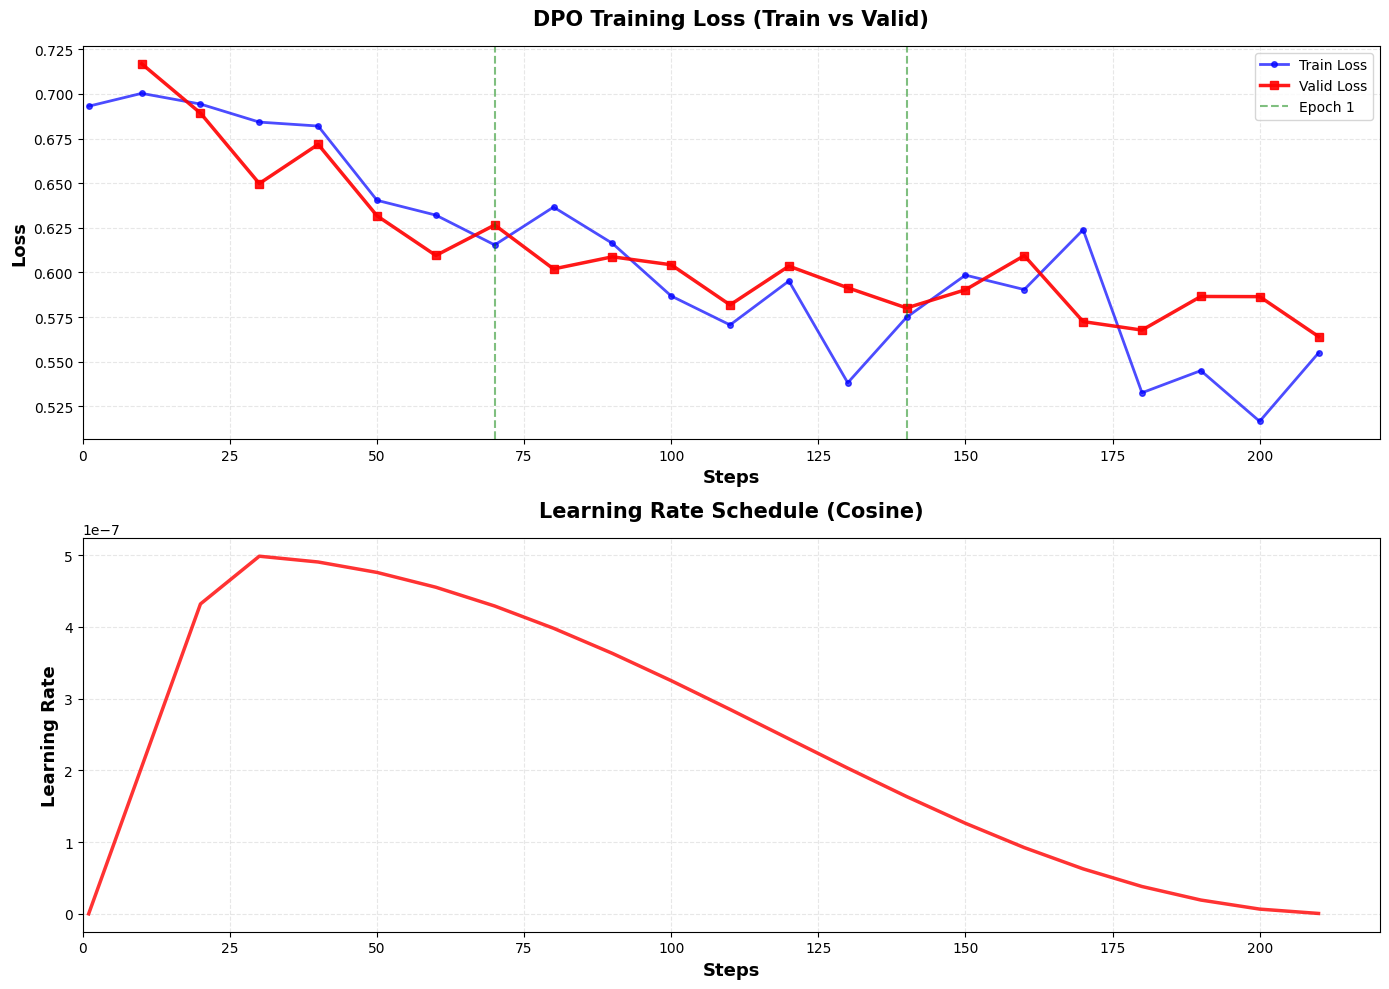


  Step     Train Loss     Valid Loss
------------------------------------
     1       0.693100               
    10       0.700300       0.716902
    20       0.694300       0.689244
    30       0.684200       0.649784
    40       0.682000       0.671732
    50       0.640400       0.631719
    60       0.632100       0.609506
    70       0.615400       0.626568
    80       0.636600       0.601956
    90       0.616300       0.608754
   100       0.586800       0.604287
   110       0.570600       0.581826
   120       0.595200       0.603541
   130       0.538200       0.591412
   140       0.574900       0.580091
   150       0.598500       0.590296
   160       0.590400       0.609410
   170       0.623900       0.572461
   180       0.532600       0.567706
   190       0.545000       0.586541
   200       0.516600       0.586445
   210       0.554900       0.564104

📈 Train Loss
   Initial: 0.693100 → Final: 0.554900 (+19.94%)
   Min: 0.516600 (step 200) | Max: 0.700300 (ste

In [ ]:
# Loss 시각화 및 분석

import json
import matplotlib.pyplot as plt
from pathlib import Path

print("학습 로그 분석 중...\n")

# 각 모델마다 이 부분만 바꿔서 실행
# output_dir = '/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model_1128_1epoch'
# output_dir = '/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model_1128_2epochs'
# output_dir = '/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model_1128_3epochs'
# output_dir = '/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model_1128_beta0.3_1epoch'
output_dir = '/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model_1207_lr5e-7_3epochs'

# 가장 최근 checkpoint 찾기
checkpoints = sorted(Path(output_dir).glob("checkpoint-*"),
                     key=lambda x: int(x.name.split('-')[1]))

if checkpoints:
    latest_checkpoint = checkpoints[-1]
    trainer_state_path = latest_checkpoint / "trainer_state.json"

    print(f"최신 체크포인트: {latest_checkpoint.name}")

    if trainer_state_path.exists():
        with open(trainer_state_path, 'r') as f:
            trainer_state = json.load(f)

        # Loss history 추출
        log_history = trainer_state.get('log_history', [])

        if log_history:
            # Step과 loss 추출 (Train + Valid 분리)
            train_steps = []
            train_losses = []
            eval_steps = []
            eval_losses = []
            learning_rates = []

            for entry in log_history:
                if 'loss' in entry:
                    train_steps.append(entry['step'])
                    train_losses.append(entry['loss'])
                    if 'learning_rate' in entry:
                        learning_rates.append(entry['learning_rate'])
                if 'eval_loss' in entry:
                    eval_steps.append(entry['step'])
                    eval_losses.append(entry['eval_loss'])

            total_steps = max(train_steps)
            num_epochs = 3
            steps_per_epoch = total_steps // num_epochs

            print(f"✅ Steps per epoch: {steps_per_epoch} | Total: {total_steps}\n")

            # 시각화
            fig, axes = plt.subplots(2, 1, figsize=(14, 10))

            # Loss plot (Train + Valid)
            axes[0].plot(train_steps, train_losses, 'b-', linewidth=2, marker='o', markersize=4, alpha=0.7, label='Train Loss')
            if eval_steps:
                axes[0].plot(eval_steps, eval_losses, 'r-', linewidth=2.5, marker='s', markersize=6, alpha=0.9, label='Valid Loss')
            axes[0].set_xlabel('Steps', fontsize=13, fontweight='bold')
            axes[0].set_ylabel('Loss', fontsize=13, fontweight='bold')
            axes[0].set_title('DPO Training Loss (Train vs Valid)', fontsize=15, fontweight='bold', pad=15)
            axes[0].grid(True, alpha=0.3, linestyle='--')
            axes[0].set_xlim(left=0)

            # Epoch 구분선 추가 (수정!)
            for i in range(1, num_epochs):
                axes[0].axvline(x=i*steps_per_epoch, color='g', linestyle='--',
                               alpha=0.5, linewidth=1.5,
                               label=f'Epoch {i}' if i == 1 else '')
            axes[0].legend(fontsize=10)

            # Learning rate plot
            if learning_rates:
                axes[1].plot(train_steps[:len(learning_rates)], learning_rates, 'r-',
                           linewidth=2.5, alpha=0.8)
                axes[1].set_xlabel('Steps', fontsize=13, fontweight='bold')
                axes[1].set_ylabel('Learning Rate', fontsize=13, fontweight='bold')
                axes[1].set_title('Learning Rate Schedule (Cosine)', fontsize=15,
                                fontweight='bold', pad=15)
                axes[1].grid(True, alpha=0.3, linestyle='--')
                axes[1].set_xlim(left=0)
                axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

            plt.tight_layout()

            # 저장
            plot_path = Path(output_dir) / "training_curves.png"
            plt.savefig(plot_path, dpi=150, bbox_inches='tight')
            print(f"📊 Loss curve 저장: {plot_path}\n")

            plt.show()

            # Train vs Valid Loss 테이블 출력
            print(f"\n{'Step':>6} {'Train Loss':>14} {'Valid Loss':>14}")
            print("-" * 36)

            eval_dict = dict(zip(eval_steps, eval_losses))
            for step, loss in zip(train_steps, train_losses):
                valid = eval_dict.get(step, None)
                valid_str = f"{valid:.6f}" if valid else ""
                print(f"{step:>6} {loss:>14.6f} {valid_str:>14}")

            # 통계 출력
            loss_reduction = train_losses[0] - train_losses[-1]
            loss_reduction_pct = (loss_reduction / train_losses[0]) * 100

            print(f"\n📈 Train Loss")
            print(f"   Initial: {train_losses[0]:.6f} → Final: {train_losses[-1]:.6f} ({loss_reduction_pct:+.2f}%)")
            print(f"   Min: {min(train_losses):.6f} (step {train_steps[train_losses.index(min(train_losses))]}) | Max: {max(train_losses):.6f} (step {train_steps[train_losses.index(max(train_losses))]})")

            if eval_losses:
                eval_reduction = eval_losses[0] - eval_losses[-1]
                eval_reduction_pct = (eval_reduction / eval_losses[0]) * 100
                print(f"\n📉 Valid Loss")
                print(f"   Initial: {eval_losses[0]:.6f} → Final: {eval_losses[-1]:.6f} ({eval_reduction_pct:+.2f}%)")
                print(f"   Min: {min(eval_losses):.6f} (step {eval_steps[eval_losses.index(min(eval_losses))]}) | Max: {max(eval_losses):.6f} (step {eval_steps[eval_losses.index(max(eval_losses))]})")

            # Epoch별 평균 loss
            print(f"\n📊 Epoch별 평균")
            for epoch in range(1, num_epochs + 1):
                epoch_start_step = (epoch - 1) * steps_per_epoch
                epoch_end_step = epoch * steps_per_epoch

                epoch_train_losses = [loss for step, loss in zip(train_steps, train_losses)
                               if epoch_start_step < step <= epoch_end_step]
                epoch_eval_losses = [loss for step, loss in zip(eval_steps, eval_losses)
                               if epoch_start_step < step <= epoch_end_step]

                if epoch_train_losses:
                    avg_train = sum(epoch_train_losses) / len(epoch_train_losses)
                    avg_eval_str = ""
                    if epoch_eval_losses:
                        avg_eval = sum(epoch_eval_losses) / len(epoch_eval_losses)
                        avg_eval_str = f" | Valid: {avg_eval:.6f}"
                    print(f"   Epoch {epoch}: Train: {avg_train:.6f}{avg_eval_str}")

            if learning_rates:
                print(f"\n⚡ LR: {learning_rates[0]:.2e} → {learning_rates[-1]:.2e}")

            # 평가
            print(f"\n✅ 평가")
            if loss_reduction_pct > 5:
                print("   학습이 잘 진행되었습니다!")
            elif loss_reduction_pct > 2:
                print("   ⚠️ Loss 감소가 적습니다. 더 긴 학습이 필요할 수 있습니다.")
            else:
                print("   ❌ Loss 감소가 매우 적습니다. 하이퍼파라미터 조정이 필요할 수 있습니다.")

            if eval_losses and len(eval_losses) >= 2:
                if eval_losses[-1] > eval_losses[0] * 1.1:
                    print("   ⚠️ Valid loss 증가 - Overfitting 가능성!")
                elif eval_losses[-1] < min(eval_losses[:-1]) if len(eval_losses) > 1 else True:
                    print("   ✅ Valid loss 감소 중 - Overfitting 없음!")

        else:
            print("Log history가 비어있습니다.")
    else:
        print(f"Trainer state 파일을 찾을 수 없습니다: {trainer_state_path}")
else:
    print(f"Checkpoint를 찾을 수 없습니다: {output_dir}")

In [ ]:
# 셀 10: SFT vs DPO 체크포인트 비교 (전체 테스트)

import random
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

print("=" * 80)
print("SFT vs DPO 모델 비교 (1128 - 전체 테스트)")
print("=" * 80)

# 경로 설정
sft_path = '/content/drive/MyDrive/Colab Notebooks/woke-odds/checkpoint-best'
base_model_name = "microsoft/Phi-4-mini-reasoning"

# 새 DPO (1128 버전 - 각 epoch별 독립 학습)
new_dpo_checkpoints = [
    ('/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model_1207_lr5e-7_1epoch/final/dpo_train', 'Epoch1'),
    ('/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model_1207_lr5e-7_2epochs/final/dpo_train', 'Epoch2'),
    ('/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model_1207_lr5e-7_3epochs/final/dpo_train', 'Epoch3'),
]

# System message
SYSTEM_MESSAGE = """You are an AI that generates a single, concise clarifying question when a user's query is ambiguous.

Task:
Generate exactly one clarifying question based on the ambiguity type.
If the query is clear and needs no clarification, output: <NO_CLARIFYING_QUESTION>

Output format: One clarifying question (or <NO_CLARIFYING_QUESTION> if not needed)

Categories:
- EM (Epistemic Misalignment): Questions with unfamiliar entities or self-contradictions
- LA (Linguistic Ambiguity): Questions with lexical or semantic ambiguity
- AO (Aleatoric Output): Questions with missing contextual information causing confusion
- NONE: Clear questions that don't require clarification

Subclasses:
For EM:
- UNF (UNFAMILIAR): Query contains unfamiliar entities or facts
- CONT (CONTRADICTION): Query contains self-contradictions

For LA:
- LEX (LEXICAL): Query contains terms with multiple meanings
- SEM (SEMANTIC): Query lacks context leading to multiple interpretations

For AO:
- WHOM: Query output contains confusion due to missing personal elements
- WHEN: Query output contains confusion due to missing temporal elements
- WHERE: Query output contains confusion due to missing spatial elements
- WHAT: Query output contains confusion due to missing task-specific elements

For Clear Questions:
- NONE: Use when require_clarification=0, output <NO_CLARIFYING_QUESTION>"""

# 전체 테스트 쿼리 (모든 카테고리)
all_queries = [
    # EM|UNF
    ("[EM|UNF] Is Maleonna a carnivore in the food chain?",
     "Can you provide more information about Maleonna?"),
    ("[EM|UNF] What's the geographic distribution of Cardamineacatiens?",
     "Can you please provide more information about Cardamineacatiens? Is it a plant, animal, or something else?"),

    # EM|CONT
    ("[EM|CONT] The all possible word categories are either \"male pronoun\" or \"religious leader\". The following two examples share a specific word category. You need to first infer the specific word category from the examples. Please output \"X\" if the given sentence mentions the specific word category. Please output \"Y\" if the given sentence does not mention the word category. Examples: He is in the laboratory with the rabbi. She is in the laboratory with the principal. The Given Sentence: He is in the hotel lobby with the ambassador.",
     "Is the category either male pronoun or religious leader?"),
    ("[EM|CONT] The all possible word categories are either \"secular leader\" or \"female pronoun\". The following two examples share a specific word category. You need to first infer the specific word category from the examples. Please output \"X\" if the given sentence mentions the specific word category. Please output \"Y\" if the given sentence does not mention the word category. Examples: She is in the grocery store with the ambassador. He is in the restaurant with the Dalai Lama. The Given Sentence: He is in the restaurant with the officer.",
     "Is the category either secular leader or female pronoun?"),

    # LA|LEX
    ("[LA|LEX] What does it mean to \"miss\" something?",
     "Are you asking about the emotional experience of longing for something that is absent, or are you referring to the act of not being able to reach or achieve something?"),
    ("[LA|LEX] What are the potential dangers associated with moles?",
     "Are you referring to moles as in small pigmented spots on the skin or moles as in small burrowing mammals?"),

    # LA|SEM
    ("[LA|SEM] Matthew told Joshua that he reassured the client. Who reassured the client?",
     "What does he refer to? Matthew or Joshua?"),
    ("[LA|SEM] The sister-in-law contacted Amanda because she has an important interview tomorrow. Who has an important interview tomorrow?",
     "What does she refer to? the sister-in-law or Amanda?"),

    # AO|WHOM
    ("[AO|WHOM] Give me a list of pizza restaurants in San Francisco",
     "What type of pizza restaurants are you looking for in San Francisco? Any specific preferences like style or price range?"),
    ("[AO|WHOM] Provide a list of some Japanese art forms I've not heard of.",
     "What Japanese art forms are you already familiar with, so I can provide a list excluding those?"),

    # AO|WHEN
    ("[AO|WHEN] Who played luna on the big comfy couch?",
     "Which time period: 1992 to 2002, or 2006?"),
    ("[AO|WHEN] Where do you go for basic training in the marines?",
     "Which time period: 1911 to 1915, after 1915, or during segregation?"),

    # AO|WHERE
    ("[AO|WHERE] The mountain range that separates europe from asia is?",
     "Which region: Caucasia, or Russia?"),
    ("[AO|WHERE] When did the suite life on deck start?",
     "In which country: uk, us, or australia and new zealand?"),

    # AO|WHAT
    ("[AO|WHAT] Fifa world cup 2014 young player of the tournament?",
     "Which one: winner, or the nominees who didn't win the award?"),
    ("[AO|WHAT] When did the facebook messenger app come out?",
     "Which event: original development as Facebook chat, or revamped release as a stand-alone app?"),
]

print(f"\n총 테스트 쿼리: {len(all_queries)}개")
print(f"카테고리: EM|UNF(2), EM|CONT(2), LA|LEX(2), LA|SEM(2), AO|WHOM(2), AO|WHEN(2), AO|WHERE(2), AO|WHAT(2)\n")

# Tokenizer 로드
print("Tokenizer 로드 중...")
tokenizer = AutoTokenizer.from_pretrained(sft_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
print("Tokenizer 로드 완료\n")

def generate_response(model, query):
    """응답 생성 함수"""
    messages = [
        {"role": "system", "content": SYSTEM_MESSAGE},
        {"role": "user", "content": query}
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    generated = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    )
    return generated.strip()

print("=" * 80)
print("테스트 시작")
print("=" * 80)

for idx, (query, expected) in enumerate(all_queries, 1):
    # Query 표시 (너무 길면 축약)
    query_display = query[:100] + "..." if len(query) > 100 else query
    expected_display = expected[:80] + "..." if len(expected) > 80 else expected

    print(f"\n테스트 {idx}/{len(all_queries)}")
    print("=" * 80)
    print(f"Query: {query_display}")
    print(f"Expected: {expected_display}")
    print("-" * 80)

    # SFT 응답
    print("\n[SFT]")
    base_model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        trust_remote_code=True
    )
    sft_model = PeftModel.from_pretrained(base_model, sft_path, is_trainable=False)
    sft_model.eval()

    sft_response = generate_response(sft_model, query)
    print(f"  {sft_response}")

    del sft_model, base_model
    torch.cuda.empty_cache()

    # DPO 응답
    for checkpoint_path, epoch_name in new_dpo_checkpoints:
        print(f"\n[DPO-{epoch_name}]")

        base = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True
        )
        m = PeftModel.from_pretrained(base, sft_path, adapter_name="sft")
        m.load_adapter(checkpoint_path, adapter_name="dpo_train")
        m.set_adapter("dpo_train")
        m.eval()

        response = generate_response(m, query)
        print(f"  {response}")

        del m, base
        torch.cuda.empty_cache()

    print("\n" + "=" * 80)

print("\n비교 완료!")
print("\n카테고리별 성능을 확인하여 어느 Epoch가 가장 균형 잡힌 성능을 보이는지 평가하세요.")

SFT vs DPO 모델 비교 (1128 - 전체 테스트)

총 테스트 쿼리: 16개
카테고리: EM|UNF(2), EM|CONT(2), LA|LEX(2), LA|SEM(2), AO|WHOM(2), AO|WHEN(2), AO|WHERE(2), AO|WHAT(2)

Tokenizer 로드 중...
Tokenizer 로드 완료

테스트 시작

테스트 1/16
Query: [EM|UNF] Is Maleonna a carnivore in the food chain?
Expected: Can you provide more information about Maleonna?
--------------------------------------------------------------------------------

[SFT]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What is the meaning of "Fossil"?

[DPO-Epoch1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which one: Is Maleonna a carnivore in the food chain?

[DPO-Epoch2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What is the type of "Maleonna"?

[DPO-Epoch3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you referring to the name "Maleonna" in this context?


테스트 2/16
Query: [EM|UNF] What's the geographic distribution of Cardamineacatiens?
Expected: Can you please provide more information about Cardamineacatiens? Is it a plant, ...
--------------------------------------------------------------------------------

[SFT]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you referring to a specific species or a type of plant?

[DPO-Epoch1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which geographic region are you referring to when you mention Cardamineacatiens?

[DPO-Epoch2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you referring to a plant species or a place in the name of a species?

[DPO-Epoch3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Can you provide more context or specify which Cardamine species or subspecies you are referring to?


테스트 3/16
Query: [EM|CONT] The all possible word categories are either "male pronoun" or "religious leader". The foll...
Expected: Is the category either male pronoun or religious leader?
--------------------------------------------------------------------------------

[SFT]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Is the specific word category mentioned in the given sentence?

[DPO-Epoch1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Is the specific word category "male pronoun"?

[DPO-Epoch2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Is the word category "male pronoun" or "religious leader"?

[DPO-Epoch3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Is the word category either "male pronoun" or "religious leader"?


테스트 4/16
Query: [EM|CONT] The all possible word categories are either "secular leader" or "female pronoun". The foll...
Expected: Is the category either secular leader or female pronoun?
--------------------------------------------------------------------------------

[SFT]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you referring to the "female pronoun" or "ambassador"?

[DPO-Epoch1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What specific word category does the given sentence mention?

[DPO-Epoch2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Is the word category "secular leader" or "female pronoun"?

[DPO-Epoch3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Is the word category either "female pronoun" or "secular leader"?


테스트 5/16
Query: [LA|LEX] What does it mean to "miss" something?
Expected: Are you asking about the emotional experience of longing for something that is a...
--------------------------------------------------------------------------------

[SFT]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you asking about the word "miss" in a specific context, such as a particular phrase or sentence?

[DPO-Epoch1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you referring to the word "miss" in the sentence "Can you miss a word"?

[DPO-Epoch2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you referring to the word "miss" in the sentence?

[DPO-Epoch3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Is the user referring to the phrase "miss" in the context of a misinterpretation or confusion?


테스트 6/16
Query: [LA|LEX] What are the potential dangers associated with moles?
Expected: Are you referring to moles as in small pigmented spots on the skin or moles as i...
--------------------------------------------------------------------------------

[SFT]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you referring to the chemical compound or the plant?

[DPO-Epoch1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you referring to the chemical element or the skin growth?

[DPO-Epoch2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you referring to the chemical element or the animal?

[DPO-Epoch3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you referring to the animal, or the skin cancer condition?


테스트 7/16
Query: [LA|SEM] Matthew told Joshua that he reassured the client. Who reassured the client?
Expected: What does he refer to? Matthew or Joshua?
--------------------------------------------------------------------------------

[SFT]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What does Matthew mean by "reassured the client"?

[DPO-Epoch1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What does "he" refer to in this sentence? Is it Matthew or Joshua?

[DPO-Epoch2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What does Matthew mean when he says "reassured the client"? Is it referring to Matthew himself or Joshua?

[DPO-Epoch3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What does "he reassured the client" refer to? Does it refer to Matthew or Joshua?


테스트 8/16
Query: [LA|SEM] The sister-in-law contacted Amanda because she has an important interview tomorrow. Who has...
Expected: What does she refer to? the sister-in-law or Amanda?
--------------------------------------------------------------------------------

[SFT]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which person is being referred to as "she" in the sentence?

[DPO-Epoch1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What does "she" refer to in the sentence "The sister-in-law contacted Amanda because she has an important interview tomorrow"? Does it refer to Amanda or the sister-in-law?

[DPO-Epoch2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Is the sister-in-law the one who contacted Amanda or is it Amanda herself?

[DPO-Epoch3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What does "she" refer to in the sentence? Is it the sister-in-law or Amanda?


테스트 9/16
Query: [AO|WHOM] Give me a list of pizza restaurants in San Francisco
Expected: What type of pizza restaurants are you looking for in San Francisco? Any specifi...
--------------------------------------------------------------------------------

[SFT]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you asking for pizza restaurants in San Francisco or do you need a list of names of individuals associated with pizza restaurants in San Francisco?

[DPO-Epoch1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you asking for the list of pizza restaurants in San Francisco or do you want me to provide the list for a specific person?

[DPO-Epoch2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you asking for a list of pizza restaurants in San Francisco, or do you want me to provide a list of something else?

[DPO-Epoch3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you asking for a list of pizza restaurants in San Francisco or do you need recommendations for a specific person?


테스트 10/16
Query: [AO|WHOM] Provide a list of some Japanese art forms I've not heard of.
Expected: What Japanese art forms are you already familiar with, so I can provide a list e...
--------------------------------------------------------------------------------

[SFT]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you asking about Japanese art forms that are unfamiliar to you, or are you referring to art forms that are unfamiliar to me?

[DPO-Epoch1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you referring to specific Japanese art forms or do you want suggestions for popular ones?

[DPO-Epoch2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which ones do you mean: which Japanese art forms have you not heard about, or which Japanese art forms have you heard about and need clarification?

[DPO-Epoch3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which Japanese art form do you mean by "where"?


테스트 11/16
Query: [AO|WHEN] Who played luna on the big comfy couch?
Expected: Which time period: 1992 to 2002, or 2006?
--------------------------------------------------------------------------------

[SFT]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you asking about who played the character on the couch, or which episode of the series featured it?

[DPO-Epoch1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which person?

[DPO-Epoch2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which person?

[DPO-Epoch3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which event?


테스트 12/16
Query: [AO|WHEN] Where do you go for basic training in the marines?
Expected: Which time period: 1911 to 1915, after 1915, or during segregation?
--------------------------------------------------------------------------------

[SFT]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which one: "The Marines" or "The Marine Corps"?

[DPO-Epoch1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which one: a place or a movie?

[DPO-Epoch2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which one: the marines or the navy?

[DPO-Epoch3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which: Where do you go for basic training in the marines?


테스트 13/16
Query: [AO|WHERE] The mountain range that separates europe from asia is?
Expected: Which region: Caucasia, or Russia?
--------------------------------------------------------------------------------

[SFT]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which mountain range?

[DPO-Epoch1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which one? The turkey plateau or the Ural mountain range?

[DPO-Epoch2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which one: the "mountain range" or "the mountain range"?

[DPO-Epoch3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which mountain range? The Taurus Mountains or the Caucasus Mountains?


테스트 14/16
Query: [AO|WHERE] When did the suite life on deck start?
Expected: In which country: uk, us, or australia and new zealand?
--------------------------------------------------------------------------------

[SFT]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which location?

[DPO-Epoch1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which location?

[DPO-Epoch2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Are you asking about the time when the "suite life on deck" began, or do you mean a specific person or location?

[DPO-Epoch3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which one: "Where" is missing the location of the incident, or which one?


테스트 15/16
Query: [AO|WHAT] Fifa world cup 2014 young player of the tournament?
Expected: Which one: winner, or the nominees who didn't win the award?
--------------------------------------------------------------------------------

[SFT]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which: The word "what" refers to a specific tournament or player?

[DPO-Epoch1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Is the query asking for the specific name of the young player who won the tournament or if the output is confused due to missing information?

[DPO-Epoch2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which one?

[DPO-Epoch3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Is the "young player of the tournament" a specific individual?


테스트 16/16
Query: [AO|WHAT] When did the facebook messenger app come out?
Expected: Which event: original development as Facebook chat, or revamped release as a sta...
--------------------------------------------------------------------------------

[SFT]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Is the question referring to the official Facebook app or the Facebook Messenger app?

[DPO-Epoch1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which one: the new version of the messenger app or the version before the update?

[DPO-Epoch2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which platform: Facebook or Instagram?

[DPO-Epoch3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which app?


비교 완료!

카테고리별 성능을 확인하여 어느 Epoch가 가장 균형 잡힌 성능을 보이는지 평가하세요.


In [ ]:
# Test 데이터셋으로 DPO 모델 평가

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel
from datasets import load_dataset
import pandas as pd

print("=" * 60)
print("Test 데이터셋 추론 평가")
print("=" * 60)

# 경로 설정
sft_path = '/content/drive/MyDrive/Colab Notebooks/woke-odds/checkpoint-best'
base_model_name = "microsoft/Phi-4-mini-reasoning"
test_path = '/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo_dataset_from_pairwise_test.jsonl'

# 평가할 DPO 체크포인트
dpo_path = '/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model_1207_lr5e-7_3epochs/final/dpo_train'

# 시스템 프롬프트 (통일!)
SYSTEM_MESSAGE = """You are an AI that generates a single, concise clarifying question when a user's query is ambiguous.

Task:
Generate exactly one clarifying question based on the ambiguity type.
If the query is clear and needs no clarification, output: <NO_CLARIFYING_QUESTION>

Output format: One clarifying question (or <NO_CLARIFYING_QUESTION> if not needed)

Categories:
- EM (Epistemic Misalignment): Questions with unfamiliar entities or self-contradictions
- LA (Linguistic Ambiguity): Questions with lexical or semantic ambiguity
- AO (Aleatoric Output): Questions with missing contextual information causing confusion
- NONE: Clear questions that don't require clarification

Subclasses:
For EM:
- UNF (UNFAMILIAR): Query contains unfamiliar entities or facts
- CONT (CONTRADICTION): Query contains self-contradictions

For LA:
- LEX (LEXICAL): Query contains terms with multiple meanings
- SEM (SEMANTIC): Query lacks context leading to multiple interpretations

For AO:
- WHOM: Query output contains confusion due to missing personal elements
- WHEN: Query output contains confusion due to missing temporal elements
- WHERE: Query output contains confusion due to missing spatial elements
- WHAT: Query output contains confusion due to missing task-specific elements

For Clear Questions:
- NONE: Use when require_clarification=0, output <NO_CLARIFYING_QUESTION>"""

# Test 데이터 로드
test_dataset = load_dataset("json", data_files=test_path)['train']
print(f"Test 데이터: {len(test_dataset)}개\n")

# Tokenizer 로드
tokenizer = AutoTokenizer.from_pretrained(sft_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# 모델 로드
print("모델 로드 중...")
base = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)
model = PeftModel.from_pretrained(base, sft_path, adapter_name="sft")
model.load_adapter(dpo_path, adapter_name="dpo_train")
model.set_adapter("dpo_train")
model.eval()
print("모델 로드 완료!\n")

def generate_response(query):
    """응답 생성 - 통일된 시스템 프롬프트 사용"""
    messages = [
        {"role": "system", "content": SYSTEM_MESSAGE},
        {"role": "user", "content": query}
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=100,
            temperature=0.3,  # 낮춤!
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    generated = tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)
    return generated.strip()

# 추론 실행
results = []
num_samples = len(test_dataset)  # 전체 141개

print(f"추론 시작 ({num_samples}개 샘플)...\n")

for i in range(num_samples):
    sample = test_dataset[i]

    # Query 추출 (user 메시지만)
    user_msg = [m for m in sample['prompt'] if m['role'] == 'user'][0]['content']
    chosen = sample['chosen'][0]['content']
    rejected = sample['rejected'][0]['content']

    # 추론 (통일된 시스템 프롬프트로!)
    prediction = generate_response(user_msg)

    results.append({
        'idx': i+1,
        'query': user_msg[:60] + '...' if len(user_msg) > 60 else user_msg,
        'chosen': chosen[:50] + '...' if len(chosen) > 50 else chosen,
        'rejected': rejected[:50] + '...' if len(rejected) > 50 else rejected,
        'prediction': prediction[:60] + '...' if len(prediction) > 60 else prediction
    })

    if (i+1) % 20 == 0:
        print(f"  {i+1}/{num_samples} 완료")

print("\n추론 완료!")

# 결과 DataFrame
df = pd.DataFrame(results)

# 테이블 출력
print("\n" + "-" * 120)
print(f"{'#':>3} {'Query':40} {'Chosen':30} {'Prediction':40}")
print("-" * 120)

for _, row in df.iterrows():
    print(f"{row['idx']:>3} {row['query']:40} {row['chosen']:30} {row['prediction']:40}")

# CSV 저장
save_path = '/content/drive/MyDrive/Colab Notebooks/woke-odds/test_inference_results.csv'
df.to_csv(save_path, index=False, encoding='utf-8-sig')
print(f"\n결과 저장: {save_path}")

# 메모리 정리
del model, base
torch.cuda.empty_cache()

Test 데이터셋 추론 평가
Test 데이터: 141개

모델 로드 중...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

모델 로드 완료!

추론 시작 (141개 샘플)...

  20/141 완료
  40/141 완료
  60/141 완료
  80/141 완료
  100/141 완료
  120/141 완료
  140/141 완료

추론 완료!

------------------------------------------------------------------------------------------------------------------------
  # Query                                    Chosen                         Prediction                              
------------------------------------------------------------------------------------------------------------------------
  1 [EM|CONT] The all possible word categories are either "indoo... X                              Is the given sentence mentioning either "indoor location" or...
  2 [AO|WHEN] When does boy in the striped pajamas take place? WHAT WHEN IS BOY IN THE STRIPED JIM JAIL? Which time period: the one before or after the event?
  3 [LA|SEM] The sister-in-law bought Amanda a drink after she a... WHOM?                          What does "she" refer to in the sentence? Is it Amanda or so...
  4 [AO|WHOM] Give me a numbe

프롬프트에 none이 없으면 이상한 출력 내는 것 확인

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

sft_path = '/content/drive/MyDrive/Colab Notebooks/woke-odds/checkpoint-best'
base_model_name = "microsoft/Phi-4-mini-reasoning"
new_dpo_path = '/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model_1127_edited_dataset/checkpoint-106/dpo_train'

# NONE 포함 프롬프트
SYSTEM_WITH_NONE = """You are an AI that generates a single, concise clarifying question when a user's query is ambiguous.

Task:
Generate exactly one clarifying question based on the ambiguity type.
If the query is clear and needs no clarification, output: <NO_CLARIFYING_QUESTION>

Output format: One clarifying question (or <NO_CLARIFYING_QUESTION> if not needed)

Categories:
- EM (Epistemic Misalignment): Questions with unfamiliar entities or self-contradictions
- LA (Linguistic Ambiguity): Questions with lexical or semantic ambiguity
- AO (Aleatoric Output): Questions with missing contextual information causing confusion
- NONE: Clear questions that don't require clarification

Subclasses:
For EM:
- UNF (UNFAMILIAR): Query contains unfamiliar entities or facts
- CONT (CONTRADICTION): Query contains self-contradictions

For LA:
- LEX (LEXICAL): Query contains terms with multiple meanings
- SEM (SEMANTIC): Query lacks context leading to multiple interpretations

For AO:
- WHOM: Query output contains confusion due to missing personal elements
- WHEN: Query output contains confusion due to missing temporal elements
- WHERE: Query output contains confusion due to missing spatial elements
- WHAT: Query output contains confusion due to missing task-specific elements

For Clear Questions:
- NONE: Use when require_clarification=0, output <NO_CLARIFYING_QUESTION>"""

# NONE 제외 프롬프트
SYSTEM_WITHOUT_NONE = """You are an AI that generates a single, concise clarifying question when a user's query is ambiguous.

Task:
Generate exactly one clarifying question based on the ambiguity type.

Output format: One clarifying question

Categories:
- EM (Epistemic Misalignment): Questions with unfamiliar entities or self-contradictions
- LA (Linguistic Ambiguity): Questions with lexical or semantic ambiguity
- AO (Aleatoric Output): Questions with missing contextual information causing confusion

Subclasses:
For EM:
- UNF (UNFAMILIAR): Query contains unfamiliar entities or facts
- CONT (CONTRADICTION): Query contains self-contradictions

For LA:
- LEX (LEXICAL): Query contains terms with multiple meanings
- SEM (SEMANTIC): Query lacks context leading to multiple interpretations

For AO:
- WHOM: Query output contains confusion due to missing personal elements
- WHEN: Query output contains confusion due to missing temporal elements
- WHERE: Query output contains confusion due to missing spatial elements
- WHAT: Query output contains confusion due to missing task-specific elements"""

test_queries = [
    "[AO|WHERE] When did call of duty ww2 come out?",
    "[LA|SEM] Melissa told Jennifer that she beguiled the father-in-law. Who beguiled the father-in-law?",
]

tokenizer = AutoTokenizer.from_pretrained(sft_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

def generate(model, query, system_msg):
    messages = [
        {"role": "system", "content": system_msg},
        {"role": "user", "content": query}
    ]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    return tokenizer.decode(outputs[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True).strip()

print("=" * 80)
print("New DPO - 프롬프트 비교 실험")
print("=" * 80)

# New DPO 로드
base = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)
model = PeftModel.from_pretrained(base, sft_path, adapter_name="sft")
model.load_adapter(new_dpo_path, adapter_name="dpo_train")
model.set_adapter("dpo_train")
model.eval()

for idx, query in enumerate(test_queries, 1):
    print(f"\n테스트 {idx}")
    print("=" * 80)
    print(f"Query: {query[:80]}...")
    print("-" * 80)

    # NONE 포함 프롬프트
    response_with = generate(model, query, SYSTEM_WITH_NONE)
    print(f"\n[NONE 포함 프롬프트]")
    print(f"  {response_with[:200]}")

    # NONE 제외 프롬프트
    response_without = generate(model, query, SYSTEM_WITHOUT_NONE)
    print(f"\n[NONE 제외 프롬프트]")
    print(f"  {response_without[:200]}")

    print()

del model, base
torch.cuda.empty_cache()

print("=" * 80)
print("실험 완료!")

New DPO - 프롬프트 비교 실험


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


테스트 1
Query: [AO|WHERE] When did call of duty ww2 come out?...
--------------------------------------------------------------------------------

[NONE 포함 프롬프트]
  Which call of duty WW2 game?

[NONE 제외 프롬프트]
  When did call of duty ww2 come out?When did call of duty ww2 come out? kuleWhen did call of duty ww2 come out?When did call of duty ww2 come out?When did call of duty ww2 come out?When did call of dut


테스트 2
Query: [LA|SEM] Melissa told Jennifer that she beguiled the father-in-law. Who beguiled...
--------------------------------------------------------------------------------

[NONE 포함 프롬프트]
  What does "she" refer to in this sentence? Is it Melissa or Jennifer?

[NONE 제외 프롬프트]
  Who beguiled the father-in-law?Who?##### Location: LA|EM
#### Subcategories: LA|UNF
Who beguiled the father-in-law?�What does "beguiled" mean in the context of "she beguiled the father-in-law"?ordi:Wh

실험 완료!
